In [1]:
import sys

sys.path.append("..")

from core.DataLoader import DataPreprocessor, get_load_config_from_yaml
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import yaml
import core.keras_models as Models
import core
import os
import keras as keras

# Configuration
if False:
    PLOTS_DIR = "plots/ToponiumInfusedTransformer/"
    MODEL_DIR = "models/mixed_model"
elif True:
    PLOTS_DIR = "plots/RegressionTransformer/"
    MODEL_DIR = "../models/model_8780384/"

else:
    PLOTS_DIR = "plots/RegressionTransformer_/"
    MODEL_DIR = "../models/regression_transformer_old/"

CONFIG_PATH = "../config/workspace_config.yaml"

# Create directories
os.makedirs(PLOTS_DIR, exist_ok=True)

# Set plotting style
plt.rcParams.update({"font.size": 18})

# Load data
load_config = get_load_config_from_yaml(CONFIG_PATH)
DataProcessor = DataPreprocessor(load_config)

data_config = DataProcessor.load_from_npz(
    load_config.data_path["nominal"], max_events=2_000_000, event_numbers="odd"
)
X, y = DataProcessor.get_data()
del DataProcessor

2026-02-04 10:46:14.103738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770198374.126166 3340057 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770198374.133674 3340057 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770198374.150853 3340057 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770198374.150875 3340057 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770198374.150878 3340057 computation_placer.cc:177] computation placer alr

## Load Model and Setup Evaluator

In [18]:
import core.reconstruction.BaselineMethods as BaselineMethods
import core.evaluation.reconstruction_evaluator as Evaluation
from core.reconstruction import (
    GroundTruthReconstructor,
    PerfectAssignmentReconstructor,
    CompositeNeutrinoComponentReconstructor,
    KerasFFRecoBase,
)

reload(Evaluation)
reload(BaselineMethods)
ground_truth_assigner = GroundTruthReconstructor(data_config, use_nu_flows=True)
transformer = KerasFFRecoBase(data_config, name=r"Transformer")
MODEL_DIR = "../models/regression_transformer/"
transformer.load_model(f"{MODEL_DIR}/odd_model.keras")
transformer_pil = KerasFFRecoBase(data_config, name=r"PIL Transformer")
MODEL_DIR = "../models/regression_transformer_pil/"
transformer_pil.load_model(f"{MODEL_DIR}/odd_model.keras")


prediction_manager = Evaluation.PredictionManager(
    [transformer,transformer_pil], X, y  # , load_directory=PREDICTIONS_DIR
)

evaluator = Evaluation.ReconstructionEvaluator(prediction_manager)

Model loaded from ../models/regression_transformer//odd_model.keras
Training history loaded from ../models/regression_transformer//odd_model_history.npz
Model loaded from ../models/regression_transformer_pil//odd_model.keras
Training history loaded from ../models/regression_transformer_pil//odd_model_history.npz


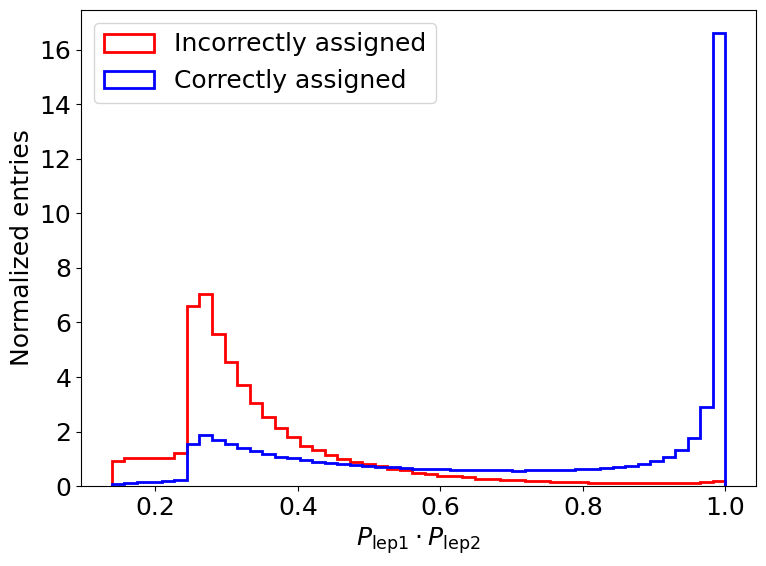

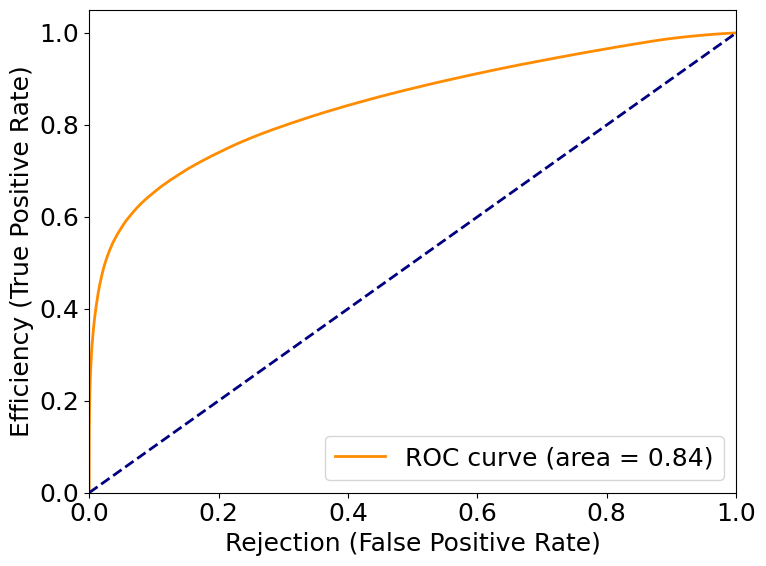

In [16]:
pred_probs = transformer_pil.model.predict_dict(X, batch_size=2048)["assignment"]
assigned_jets = transformer_pil.generate_one_hot_encoding(pred_probs, exclusive=True)
correct_assignments = np.all(assigned_jets == y["assignment"], axis=(1, 2))

prob_lep_1 = (pred_probs * assigned_jets)[:, :, 0:1].sum(axis=1, keepdims=True)
prob_lep_2 = (pred_probs * assigned_jets)[:, :, 1:2].sum(axis=1, keepdims=True)
probs = prob_lep_1 * prob_lep_2

fig, ax = plt.subplots(figsize=(8, 6))
bins = np.linspace(np.percentile(probs, 0.5), np.percentile(probs, 99.5), 50)
ax.hist(
    probs[~correct_assignments].flatten(),
    histtype="step",
    bins=bins,
    label="Incorrectly assigned",
    density=True,
    color="red",
    linewidth=2,
)
ax.hist(
    probs[correct_assignments].flatten(),
    histtype="step",
    bins=bins,
    label="Correctly assigned",
    density=True,
    color="blue",
    linewidth=2,
)
ax.set_xlabel(r"$P_{\mathrm{lep 1}} \cdot P_{\mathrm{lep 2}}$")
ax.set_ylabel("Normalized entries")
ax.legend()
fig.tight_layout()
fig.savefig(f"{PLOTS_DIR}/assignment_probabilities.png")
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(
    correct_assignments.astype(int), probs.flatten()
)
roc_auc = auc(fpr, tpr)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("Rejection (False Positive Rate)")
ax.set_ylabel("Efficiency (True Positive Rate)")
ax.legend(loc="lower right")
fig.tight_layout()
fig.savefig(f"{PLOTS_DIR}/false_assignment_prediction_roc_curve.png")


Computing binned accuracy quotients for truth_ttbar_mass...


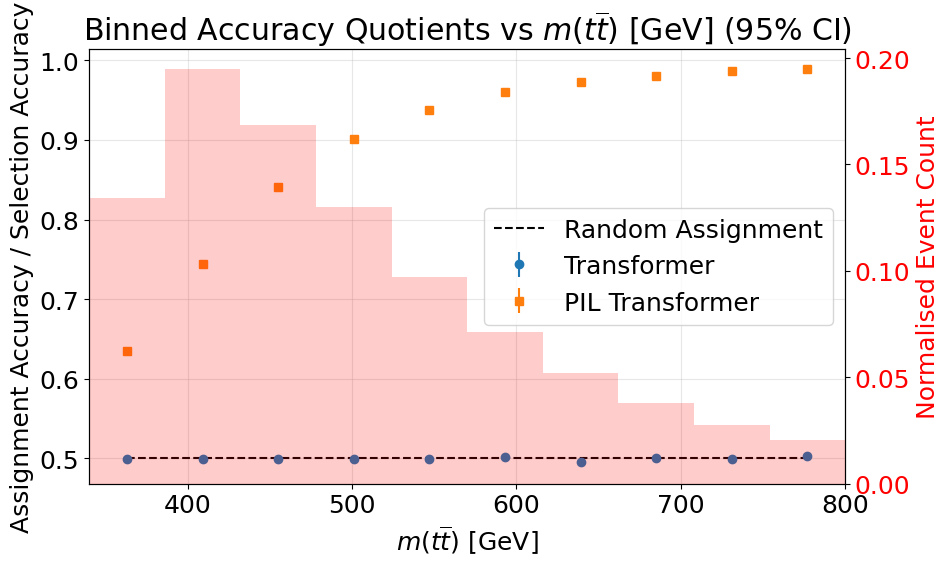

In [17]:
fig, ax = evaluator.plot_binned_accuracy_quotients(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "binned_accuracy_quotient_ttbar_mass.pdf")

In [ ]:
evaluator.save_accuracy_latex_table(
    n_bootstrap=100, confidence=0.95, save_dir=PLOTS_DIR
)

In [ ]:
fig, ax = evaluator.plot_all_accuracies(n_bootstrap=10)
fig.savefig(PLOTS_DIR + "all_accuracies.pdf")

In [ ]:
fig, ax = evaluator.plot_all_selection_accuracies(n_bootstrap=10)
fig.savefig(PLOTS_DIR + "all_selection_accuracies.pdf")

In [ ]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="N_jets",
    fancy_feature_label=r"$\# \text{jets}$",
    xlims=(2, data_config.max_jets + 1),
    bins=data_config.max_jets - 1,
    n_bootstrap=10,
)
ax.set_xticks([i + 0.5 for i in range(2, data_config.max_jets + 1)])
ax.set_xticklabels([i for i in range(2, data_config.max_jets + 1)])
ax.legend(loc="lower left")
fig.savefig(PLOTS_DIR + "binned_accuracy_N_jets.pdf")

In [ ]:
fig, ax = evaluator.plot_binned_accuracy_quotients(
    feature_data_type="non_training",
    feature_name="N_jets",
    fancy_feature_label=r"$\# \text{jets}$",
    xlims=(2, data_config.max_jets + 1),
    bins=data_config.max_jets - 1,
    n_bootstrap=10,
)
ax.set_xticks([i + 0.5 for i in range(2, data_config.max_jets + 1)])
ax.set_xticklabels([i for i in range(2, data_config.max_jets + 1)])
ax.set_xlim(2, data_config.max_jets + 1)
ax.legend(loc="lower left")
fig.savefig(PLOTS_DIR + "binned_accuracy_quotients_N_jets.pdf")

In [ ]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "binned_accuracy_ttbar_mass.pdf")

In [ ]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_pt",
    fancy_feature_label=r"$p_T(t\overline{t})$ [GeV]",
    xlims=(0, 400e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(0, 400e3)
fig.savefig(PLOTS_DIR + "binned_accuracy_ttbar_pT.pdf")

In [ ]:
fig, ax = evaluator.plot_binned_accuracy_quotients(
    feature_data_type="non_training",
    feature_name="truth_ttbar_pt",
    fancy_feature_label=r"$p_T(t\overline{t})$ [GeV]",
    xlims=(0, 400e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(0, 400e3)
fig.savefig(PLOTS_DIR + "binned_accuracy_quotient_ttbar_pT.pdf")

In [ ]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="dR_l1l2",
    fancy_feature_label=r"$\Delta R(\ell_1,\ell_2)$",
    xlims=(0, 5),
    bins=10,
    n_bootstrap=10,
)
ax.set_xlim(0, 5)
fig.savefig(PLOTS_DIR + "binned_accuracy_dR_l1l2.pdf")

In [ ]:
fig, ax = evaluator.plot_binned_selection_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    bins=10,
    n_bootstrap=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "binned_selection_accuracy_ttbar_mass.pdf")

In [ ]:
fig, ax = evaluator.plot_binned_selection_accuracy(
    feature_data_type="non_training",
    feature_name="N_jets",
    fancy_feature_label=r"$\# \text{jets}$",
    xlims=(3, data_config.max_jets + 1),
    bins=data_config.max_jets - 2,
    n_bootstrap=10,
)
ax.set_xticks([i + 0.5 for i in range(3, data_config.max_jets + 1)])
ax.set_xticklabels([i for i in range(3, data_config.max_jets + 1)])
ax.legend(loc="lower left")
fig.savefig(PLOTS_DIR + "binned_selection_accuracy_N_jets.pdf")

In [ ]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_initial_parton_num_gluons",
    fancy_feature_label=r"Initial State",
    xlims=(0, 3),
    bins=3,
    n_bootstrap=10,
)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels([r"$qq\to tt$", r"$qg\to tt$", r"$gg\to tt$"])
fig.savefig(PLOTS_DIR + "binned_accuracy_initial_state.pdf")

In [ ]:
fig, ax = evaluator.plot_binned_selection_accuracy(
    feature_data_type="non_training",
    feature_name="truth_initial_parton_num_gluons",
    fancy_feature_label=r"Initial State",
    xlims=(0, 3),
    bins=3,
    n_bootstrap=10,
)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels([r"$qq\to tt$", r"$qg\to tt$", r"$gg\to tt$"])
fig.savefig(PLOTS_DIR + "binned_selection_accuracy_initial_state.pdf")

In [ ]:
fig, ax = evaluator.plot_binned_accuracy_quotients(
    feature_data_type="non_training",
    feature_name="truth_initial_parton_num_gluons",
    fancy_feature_label=r"Initial State",
    xlims=(0, 3),
    bins=3,
    n_bootstrap=10,
)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels([r"$qq\to tt$", r"$qg\to tt$", r"$gg\to tt$"])
fig.savefig(PLOTS_DIR + "binned_accuracy_quotients_initial_state.pdf")

In [ ]:
fig, ax = evaluator.plot_confusion_matrices()
fig.savefig(PLOTS_DIR + "confusion_matrices.pdf")

In [ ]:
fig, ax = evaluator.plot_complementarity_matrix(figsize=(10.5, 10))
fig.savefig(PLOTS_DIR + "complementarity_matrix.pdf")